In [398]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
import pulp as p

In [373]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Cleansing

In [374]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [375]:
#As bmi contains null values
df.bmi = df.bmi.fillna(-99)

In [376]:
# define target variable
target = df.stroke


# calc frequencies
target_count = target.value_counts()
print(target_count)
print('Percentage of strokes [1]:', np.round(100*target_count[1] / target_count.sum(),2), '%')

0    4861
1     249
Name: stroke, dtype: int64
Percentage of strokes [1]: 4.87 %


In [377]:
df1 = df 
ever_married_mapping = {'No': 0, 'Yes': 1}
df1['ever_married'] = df1['ever_married'].map(ever_married_mapping)
Residence_type_mapping = {'Rural': 0, 'Urban': 1}
df1['Residence_type'] = df1['Residence_type'].map(Residence_type_mapping)

datasetDummies_gender = pd.get_dummies(df1['gender'], prefix = 'gender_encoded')
datasetDummies_work_type = pd.get_dummies(df1['work_type'], prefix = 'work_type_encoded') 
datasetDummies_smoking_status = pd.get_dummies(df1['smoking_status'], prefix = 'smoking_status_encoded')

target1 = pd.get_dummies(target, prefix = 'target')

df1.drop("gender", axis=1, inplace=True)
df1.drop("work_type", axis=1, inplace=True)
df1.drop("smoking_status", axis=1, inplace=True)
df1.drop("stroke", axis=1, inplace=True)



In [378]:
scaler = MinMaxScaler()
arr = scaler.fit_transform(df1[['bmi', 'avg_glucose_level', 'age']])
column_names = ['bmi', 'avg_glucose_level', 'age']
dframe = pd.DataFrame(arr, columns = column_names)
df1.drop(['bmi', 'avg_glucose_level', 'age'], axis=1, inplace=True)


In [379]:
df1 = pd.concat([df1, datasetDummies_gender], axis=1)
df1 = pd.concat([df1, datasetDummies_work_type], axis=1)
df1 = pd.concat([df1, datasetDummies_smoking_status], axis=1)
df1 = pd.concat([df1, dframe], axis=1)

df1.head()

,id,hypertension,heart_disease,ever_married,Residence_type,gender_encoded_Female,gender_encoded_Male,gender_encoded_Other,work_type_encoded_Govt_job,work_type_encoded_Never_worked,work_type_encoded_Private,work_type_encoded_Self-employed,work_type_encoded_children,smoking_status_encoded_Unknown,smoking_status_encoded_formerly smoked,smoking_status_encoded_never smoked,smoking_status_encoded_smokes,bmi,avg_glucose_level,age
0,9046,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0.689725,0.801265,0.816895
1,51676,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0.000000,0.679023,0.743652
2,31112,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0.668871,0.234512,0.975586
3,60182,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0.678535,0.536008,0.597168
4,1665,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0.625636,0.549349,0.963379


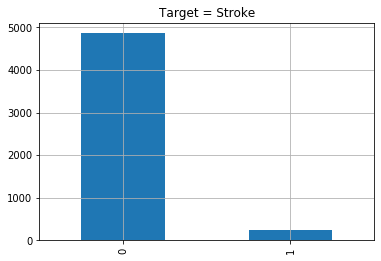

In [380]:
target_count.plot(kind='bar')
plt.title('Target = Stroke')
plt.grid()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(df1.iloc[:,1:], target1, test_size=0.30, random_state=42)

## Feature Engineering

C:\Users\Daim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


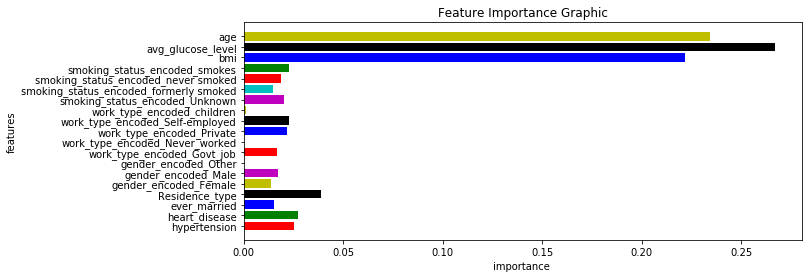

In [381]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
  
best_features = SelectFromModel(model)
best_features.fit(X_train, y_train)
features = df1.columns[1:]
imp_feature = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
plt.figure(figsize=(10,4))
plt.title("Feature Importance Graphic")
plt.xlabel("importance ")
plt.ylabel("features")
plt.barh(imp_feature['Feature'],imp_feature['Importance'],color = 'rgbkymc')
plt.show()


Will use only the five features namely bmi, avg_glucose_level , age, work_type_encoded_children and hypertension.

In [382]:
X_train = X_train[['bmi', 'avg_glucose_level', 'age', 'work_type_encoded_children' , 'hypertension']]

## Model building

In [383]:
model = Sequential()
model.add(Dense(32, input_dim=5, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
3577/3577 [==============================] - 7s 2ms/step - loss: 0.2934 - accuracy: 0.9547
Epoch 2/10
3577/3577 [==============================] - 1s 320us/step - loss: 0.1620 - accuracy: 0.9553
Epoch 3/10
3577/3577 [==============================] - 1s 287us/step - loss: 0.1508 - accuracy: 0.9553
Epoch 4/10
3577/3577 [==============================] - 1s 353us/step - loss: 0.1489 - accuracy: 0.9553
Epoch 5/10
3577/3577 [==============================] - 1s 349us/step - loss: 0.1459 - accuracy: 0.9553
Epoch 6/10
3577/3577 [==============================] - 1s 302us/step - loss: 0.1464 - accuracy: 0.9553
Epoch 7/10
3577/3577 [==============================] - 1s 290us/step - loss: 0.1442 - accuracy: 0.9553
Epoch 8/10
3577/3577 [==============================] - 1s 345us/step - loss: 0.1443 - accuracy: 0.95530s -
Epoch 9/10
3577/3577 [==============================] - 1s 278us/step - loss: 0.1437 - accuracy: 0.9553
Epoch 10/10
3577/3577 [==============================] - 1s 29

In [384]:
prediction = model.predict(X_test[['bmi', 'avg_glucose_level', 'age', 'work_type_encoded_children' , 'hypertension']])
print(prediction[0], '\n',y_test.iloc[0])

[0.9944747  0.00552532] 
 target_0    1
target_1    0
Name: 4688, dtype: uint8


The predicted array have 2 values for each observation which is actually the probability of whether the stroke happens or not.  

In [385]:
from itertools import combinations
def powerset(string):
    lis = []
    for i in range(1,len(string)+1):
        for element in combinations(string,i):
            lis.append(element)
    
    return lis

In [386]:
def directkb(data):
    counts=dict()
    kb = dict()
    features = ['bmi', 'avg_glucose_level', 'age', 'work_type_encoded_children' , 'hypertension']
    rang = len(data)
    for i in range(0,rang):
        feaVal = []
        for ind in range(0,5):
            feaVal.append((features[ind], data.iloc[i][ind]))
        label= target[i]
        s = powerset(feaVal)
        for key in s:
            if key in counts:
                counts[key] = [counts[key][0]+1, counts[key][0]+label]
            else:
                counts[key] = [1,label]
    for key in counts:
        r = counts[key][1]/counts[key][0]
        if r != 0 :
            kb[key] = r
    return kb

In [387]:
kb_data = directkb(X_train.iloc[:,:])

In [388]:
def relevant_kb(query,kb):
    features = ['bmi', 'avg_glucose_level', 'age', 'work_type_encoded_children' , 'hypertension']
    feaVal = []
    rel_kb = dict()
    for ind in range(0,5):
            feaVal.append((features[ind], query[ind]))
    s = powerset(feaVal)
    for key in s:
        for rel_key in kb:
            if key == rel_key:
                rel_kb[key]=kb[rel_key]
    return rel_kb

In [389]:
que = X_test[['bmi', 'avg_glucose_level', 'age', 'work_type_encoded_children' , 'hypertension']].iloc[0]
rlu = relevant_kb(que,kb_data)
print(rlu)

{(('bmi', 0.6205493387589014),): 0.9285714285714286, (('age', 0.37744140625),): 0.9818181818181818, (('work_type_encoded_children', 0.0),): 0.9996786632390745, (('hypertension', 0.0),): 0.9996923076923077, (('bmi', 0.6205493387589014), ('work_type_encoded_children', 0.0)): 0.9090909090909091, (('bmi', 0.6205493387589014), ('hypertension', 0.0)): 0.9285714285714286, (('age', 0.37744140625), ('work_type_encoded_children', 0.0)): 0.9818181818181818, (('age', 0.37744140625), ('hypertension', 0.0)): 0.9814814814814815, (('work_type_encoded_children', 0.0), ('hypertension', 0.0)): 0.999640933572711, (('bmi', 0.6205493387589014), ('work_type_encoded_children', 0.0), ('hypertension', 0.0)): 0.9090909090909091, (('age', 0.37744140625), ('work_type_encoded_children', 0.0), ('hypertension', 0.0)): 0.9814814814814815}


In [395]:
def query_kb(query):
    features = ['bmi', 'avg_glucose_level', 'age', 'work_type_encoded_children' , 'hypertension']
    probs = dict()
    for i, feature in enumerate(features):
            if query[i]<0.5:
                probs[(feature,0)] = 1
                probs[(feature,1)] = 0 
            else:
                probs[(feature,0)] = 0
                probs[(feature,1)] = 1
    return probs

In [397]:
print(query_kb(que))


{('bmi', 0): 0, ('bmi', 1): 1, ('avg_glucose_level', 0): 1, ('avg_glucose_level', 1): 0, ('age', 0): 1, ('age', 1): 0, ('work_type_encoded_children', 0): 1, ('work_type_encoded_children', 1): 0, ('hypertension', 0): 1, ('hypertension', 1): 0}


In [ ]:
def linear_solvr(kb, probab):
    